In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore')


In [2]:
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable

from PIL import Image
import cv2
import albumentations as A

import time
import os
from tqdm.notebook import tqdm

from torchsummary import summary
import segmentation_models_pytorch as smp

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
image_path = 'data/semantic_drone_dataset/original_images/'
mask_path = 'data/semantic_drone_dataset/label_images_semantic/'

In [4]:
n_classes = 23 

def create_df():
    name = []
    # 하위의 폴더들을 for문으로 탐색할 수 있게 해줍니다. 인자로 전달된 path에 대해서 다음 3개의 값이 있는 tuple을 넘겨줍니다.
    for dirname, _, filenames in os.walk(image_path):
        for filename in filenames:
            name.append(filename.split('.')[0])
    
    return pd.DataFrame({'id': name}, index = np.arange(0, len(name)))

df = create_df()
print('Total Images: ', len(df))

Total Images:  400


In [5]:
df.head(1)

,id
0,162


In [6]:
# split data

X_trainval, X_test = train_test_split(df['id'].values, test_size=0.1, random_state=19)
X_train, X_val = train_test_split(X_trainval, test_size=0.15, random_state=19)

print('Train Size   : ', len(X_train))
print('Val Size     : ', len(X_val))
print('Test Size    : ', len(X_test))

Train Size   :  306
Val Size     :  54
Test Size    :  40


In [7]:
df['id'][100]

'075'

Image Size (4000, 6000, 3)
Mask Size (4000, 6000)


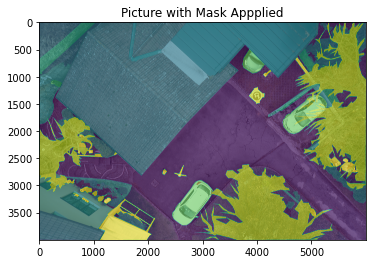

In [9]:
img = Image.open(image_path + df['id'][100] + '.jpg')
mask = Image.open(mask_path + df['id'][100] + '.png')
print('Image Size', np.asarray(img).shape)
print('Mask Size', np.asarray(mask).shape)


plt.imshow(img)
plt.imshow(mask, alpha=0.6)
plt.title('Picture with Mask Appplied')
plt.show()

### Dataset 



In [10]:
class DroneDataset(Dataset):
    
    def __init__(self, img_path, mask_path, X, mean, std, transform=None, patch=False):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform
        self.patches = patch
        self.mean = mean
        self.std = std
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)
        
        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
        
        if self.transform is None:
            img = Image.fromarray(img)
        
        t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
        img = t(img)
        mask = torch.from_numpy(mask).long()
        
        if self.patches:
            img, mask = self.tiles(img, mask)
            
        return img, mask
    
    def tiles(self, img, mask):

        img_patches = img.unfold(1, 512, 512).unfold(2, 768, 768) 
        img_patches  = img_patches.contiguous().view(3,-1, 512, 768) 
        img_patches = img_patches.permute(1,0,2,3)
        
        mask_patches = mask.unfold(0, 512, 512).unfold(1, 768, 768)
        mask_patches = mask_patches.contiguous().view(-1, 512, 768)
        
        return img_patches, mask_patches

In [11]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

t_train = A.Compose([A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(), A.VerticalFlip(), 
                     A.GridDistortion(p=0.2), A.RandomBrightnessContrast((0,0.5),(0,0.5)),
                     A.GaussNoise()])

t_val = A.Compose([A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(),
                   A.GridDistortion(p=0.2)])

#datasets
train_set = DroneDataset(image_path, mask_path, X_train, mean, std, t_train, patch=False)
val_set = DroneDataset(image_path, mask_path, X_val, mean, std, t_val, patch=False)

#dataloader
batch_size= 3 

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)               

### Model 

In [15]:
# Pretrained model 
model = smp.Unet('efficientnet-b1', encoder_weights='imagenet', classes=23, activation=None, encoder_depth=5, decoder_channels=[256, 128, 64, 32, 16])

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b1-f1951068.pth" to /Users/wonminjae/.cache/torch/hub/checkpoints/efficientnet-b1-f1951068.pth


  0%|          | 0.00/30.1M [00:00<?, ?B/s]

In [16]:
model

Unet(
  (encoder): EfficientNetEncoder(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          32, 8, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          8, 32, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_project_conv): Conv2dStaticSamePadding

### Training

In [17]:
def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

In [20]:
def mIlou(pred_mask , mask, smooth = 1e-10, n_classes =23 ) :
    with torch.no_grad() :
        pred_mask = F.softmax(pred_mask, dim =1)
        pred_mask = torch.argmax(pred_mask, dim = 1)
        # 연속적인 메모리 텐서를 반환하는 메서드로 만약 어떤 연산을 사용할때 이를 사용하지 않으면 에러가 발생하는 경우가 생긴다.
        pred_mask = pred_mask.contiguous().view(-1)
        
        iou_per_classs = []
        for c in range(0, n_classes) :  #loop per pixel class
            true_class = pred_mask ==c
            true_label = pred_mask ==c
            
            if true_label.long().sum().item() == 0 : #no exist label in this loop
                iou_per_class.append(np.nan)
            else :
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()
                # Computes the element-wise logical AND of the given input tensors. 
                # Zeros are treated as False and nonzeros are treated as True.
                iou = (intersect + smooth) / (union +smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)

In [ ]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit(epochs, model, train_loader, val_loader, criterion, optimizer, scheduler, patch=False):
    torch.cuda.empty_cache()
    train_losses = []
    test_losses = []
    val_iou = []; val_acc = []
    train_iou = []; train_acc = []
    lrs = []
    min_loss = np.inf
    decrease = 1 ; not_improve=0
    
    
    model.to(device)
    fit_time = time.time()
    for e in range(epochs):
        since = time.time()
        running_loss = 0
        iou_score = 0
        accuracy = 0
        #training loop
        model.train()
        for i, data in enumerate(tqdm(train_loader)):
            #training phase
            image_tiles, mask_tiles = data
            if patch:
                bs, n_tiles, c, h, w = image_tiles.size()

                image_tiles = image_tiles.view(-1,c, h, w)
                mask_tiles = mask_tiles.view(-1, h, w)
                
            image = image_tiles.to(device); mask = mask_tiles.to(device);
            #forward
            output = model(image)
            loss = criterion(output, mask)
            #evaluation metrics
            iou_score += mIoU(output, mask)
            accuracy += pixel_accuracy(output, mask)
            #backward
            loss.backward()
            optimizer.step() #update weight          
            optimizer.zero_grad() #reset gradient
            
            #step the learning rate
            lrs.append(get_lr(optimizer))
            scheduler.step() 
            
            running_loss += loss.item()
        
         else:
            model.eval()
            test_loss = 0
            test_accuracy = 0
            val_iou_score = 0
            #validation loop
            with torch.no_grad():
                for i, data in enumerate(tqdm(val_loader)):
                    #reshape to 9 patches from single image, delete batch size
                    image_tiles, mask_tiles = data
                    
                    if patch:
                        bs, n_tiles, c, h, w = image_tiles.size()

                        image_tiles = image_tiles.view(-1,c, h, w)
                        mask_tiles = mask_tiles.view(-1, h, w)
                    
                    image = image_tiles.to(device); mask = mask_tiles.to(device);
                    output = model(image)
                    #evaluation metrics
                    val_iou_score +=  mIoU(output, mask)
                    test_accuracy += pixel_accuracy(output, mask)
                    #loss
                    loss = criterion(output, mask)                                  
                    test_loss += loss.item()
            
            #calculatio mean for each batch
            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(val_loader))


            if min_loss > (test_loss/len(val_loader)):
                print('Loss Decreasing.. {:.3f} >> {:.3f} '.format(min_loss, (test_loss/len(val_loader))))
                min_loss = (test_loss/len(val_loader))
                decrease += 1
                if decrease % 5 == 0:
                    print('saving model...')
                    torch.save(model, 'Unet-Mobilenet_v2_mIoU-{:.3f}.pt'.format(val_iou_score/len(val_loader)))
                
                
            if (test_loss/len(val_loader)) > min_loss:
                not_improve += 1
                min_loss = (test_loss/len(val_loader))
                print(f'Loss Not Decrease for {not_improve} time')
                if not_improve == 7:
                    print('Loss not decrease for 7 times, Stop Training')
                    break
                    
                    
              #iou
            val_iou.append(val_iou_score/len(val_loader))
            train_iou.append(iou_score/len(train_loader))
            train_acc.append(accuracy/len(train_loader))
            val_acc.append(test_accuracy/ len(val_loader))
            print("Epoch:{}/{}..".format(e+1, epochs),
                  "Train Loss: {:.3f}..".format(running_loss/len(train_loader)),
                  "Val Loss: {:.3f}..".format(test_loss/len(val_loader)),
                  "Train mIoU:{:.3f}..".format(iou_score/len(train_loader)),
                  "Val mIoU: {:.3f}..".format(val_iou_score/len(val_loader)),
                  "Train Acc:{:.3f}..".format(accuracy/len(train_loader)),
                  "Val Acc:{:.3f}..".format(test_accuracy/len(val_loader)),
                  "Time: {:.2f}m".format((time.time()-since)/60))
    
    history = {'train_loss' : train_losses, 'val_loss': test_losses,
               'train_miou' :train_iou, 'val_miou':val_iou,
               'train_acc' :train_acc, 'val_acc':val_acc,
               'lrs': lrs}
    print('Total time: {:.2f} m' .format((time.time()- fit_time)/60))
    return history